In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/home/ext-daniel-packer/documents/Github/vote-counts


In [4]:
import pandas as pd
from pathlib import Path
import numpyro
from numpyro import distributions as dist
from numpyro.infer import NUTS, MCMC, Predictive
from jax import random, numpy as jnp
import jax
import matplotlib.pyplot as plt
import seaborn as sns
import os
# from scipy import stats
from src import preprocessing
import numpy as np
from numpyro.infer import (
    MCMC,
    NUTS,
    init_to_feasible,
    init_to_median,
    init_to_sample,
    init_to_uniform,
    init_to_value,
)
import time

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

path_data = Path("data")
path_raw_data = path_data / "raw_data"

rngs = random.split(random.PRNGKey(seed=1), 10)

In [5]:
def get_pivot_odds(df):
    for ind, row in df.iterrows():
        mean_p = row["p_democrat"]
        std_p = row["std_p_democrat"]
        df.loc[ind, "p_05"] = stats.t.pdf(0.5, 4, loc=mean_p, scale=std_p)

    df["pivot_odds"] = df["p_05"] / df["total_votes"]
    df["log_pivot_odds"] = np.log(df["p_05"] / df["total_votes"])
    return df

In [6]:
raw_data = pd.read_csv(path_raw_data / "President_2000-2020.csv")

In [7]:
# Preprocessing:
# Drop rows where county fips isn't well-defined (most of these rows have zero votes)
raw_data = raw_data[~raw_data["county_fips"].isna()]
raw_data["county_fips"] = (
    raw_data["county_fips"].astype(int).astype(str).apply(lambda i: str(i).zfill(5))
)
raw_data["party"] = raw_data["party"].astype(str)
raw_data = raw_data.query("party == 'REPUBLICAN' or party == 'DEMOCRAT'")

In [8]:
groupby = ["county_fips", "year", "party"]
votes_over_time = (
    raw_data[[*groupby, "candidatevotes"]]
    .groupby(groupby)
    .sum()
    .reset_index()
    .pivot_table(
        index=["county_fips", "year"], columns="party", values="candidatevotes"
    )
)
votes_over_time["total_votes"] = (
    votes_over_time["DEMOCRAT"] + votes_over_time["REPUBLICAN"]
)
votes_over_time["p_DEMOCRAT"] = (
    votes_over_time["DEMOCRAT"] / votes_over_time["total_votes"]
)

In [9]:
def kernel(X, Z, var, length, noise, jitter=1.0e-6, include_noise=True):
    deltaXsq = jnp.power((X[:, None] - Z) / length, 2.0)
    k = var * jnp.exp(-0.5 * deltaXsq)
    if include_noise:
        k += (noise + jitter) * jnp.eye(X.shape[0])
    return k


def model(X, Y):
    # set uninformative log-normal priors on our three kernel hyperparameters
    var = numpyro.sample("kernel_var", dist.LogNormal(0.0, 1.0))
    noise = numpyro.sample("kernel_noise", dist.LogNormal(0.0, 1.0))
    length = numpyro.sample("kernel_length", dist.LogNormal(0.0, 1.0))

    # compute kernel
    k = kernel(X, X, var, length, noise)

    # sample Y according to the standard gaussian process formula
    numpyro.sample(
        "Y",
        dist.MultivariateNormal(loc=jnp.zeros(X.shape[0]), covariance_matrix=k),
        obs=Y,
    )

vec_kernel = jax.jit(jax.vmap(kernel, (None, None, None, None, 0)))

def model2(X, Ys):
    n_counties = len(Ys)
    # set uninformative log-normal priors on our three kernel hyperparameters
    var = numpyro.sample("kernel_var", dist.LogNormal(0.0, 1.0))
    length = numpyro.sample("kernel_length", dist.LogNormal(0.0, 1.0))
    noise_loc = numpyro.sample("kernel_noise_loc", dist.Normal(-3.0, 2.0))

    with numpyro.plate("county", n_counties) as ind:
        noise = numpyro.sample(
            "kernel_noise", dist.LogNormal(noise_loc, 0.1)
        )
        # compute kernel
        k = vec_kernel(X, X, var, length, noise)

        # sample Y according to the standard gaussian process formula
        numpyro.sample(
            "Y",
            dist.MultivariateNormal(loc=jnp.zeros(X.shape[0]), covariance_matrix=k),
            obs=Ys[ind],
        )

vec_kernel = jax.jit(jax.vmap(kernel, (None, None, 0, None, None)))

def model3(X, Ys):
    n_counties = len(Ys)
    # set uninformative log-normal priors on our three kernel hyperparameters
    length = numpyro.sample("kernel_length", dist.LogNormal(0.0, 1.0))
    var_loc = numpyro.sample("kernel_var_loc", dist.Normal(0, 2.0))
    noise = numpyro.sample("kernel_noise", dist.LogNormal(0.0, 1.0))

    with numpyro.plate("county", n_counties) as ind:
        var = numpyro.sample(
            "kernel_var", dist.LogNormal(var_loc, 0.1)
        )
        # compute kernel
        k = vec_kernel(X, X, var[ind], length, noise)

        # sample Y according to the standard gaussian process formula
        numpyro.sample(
            "Y",
            dist.MultivariateNormal(loc=jnp.zeros(X.shape[0]), covariance_matrix=k),
            obs=Ys[ind],
        )


# helper function for doing hmc inference
def run_inference(model, args, rng_key, *model_params, fullmcmc = False):
    start = time.time()
    # demonstrate how to use different HMC initialization strategies
    if args["init_strategy"] == "value":
        init_strategy = init_to_value(
            values={"kernel_var": 1.0, "kernel_noise": 0.05, "kernel_length": 0.5}
        )
    elif args["init_strategy"] == "median":
        init_strategy = init_to_median(num_samples=10)
    elif args["init_strategy"] == "feasible":
        init_strategy = init_to_feasible()
    elif args["init_strategy"] == "sample":
        init_strategy = init_to_sample()
    elif args["init_strategy"] == "uniform":
        init_strategy = init_to_uniform(radius=1)
    kernel = NUTS(model)#, init_strategy=init_strategy)
    mcmc = MCMC(
        kernel,
        num_warmup=args["num_warmup"],
        num_samples=args["num_samples"],
        num_chains=args["num_chains"],
        # thinning=args["thinning"],
        progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
    )
    mcmc.run(rng_key, *model_params)
    mcmc.print_summary()
    print("\nMCMC elapsed time:", time.time() - start)
    return mcmc.get_samples() if not fullmcmc else mcmc


def predict(rng_key, X, Y, X_test, var, length, noise):
    # compute kernels between train and test data, etc.
    k_pp = kernel(X_test, X_test, var, length, noise, include_noise=True)
    k_pX = kernel(X_test, X, var, length, noise, include_noise=False)
    k_XX = kernel(X, X, var, length, noise, include_noise=True)
    K_xx_inv = jnp.linalg.inv(k_XX)
    K = k_pp - jnp.matmul(k_pX, jnp.matmul(K_xx_inv, jnp.transpose(k_pX)))
    sigma_noise = jnp.sqrt(jnp.clip(jnp.diag(K), a_min=0.0)) * jax.random.normal(
        rng_key, X_test.shape[:1]
    )
    mean = jnp.matmul(k_pX, jnp.matmul(K_xx_inv, Y))
    # we return both the mean function and a sample from the posterior predictive for the
    # given set of hyperparameters
    return mean, mean + sigma_noise

In [38]:
Y = jax.scipy.special.logit(votes_over_time.loc["01001", "p_DEMOCRAT"].to_numpy())
X = votes_over_time.loc["01001"].reset_index()["year"].to_numpy()

args = {
    "init_strategy": "value",
    "num_warmup": 500,
    "num_samples": 2_000,
    "num_chains": 1,
}
samples = run_inference(model, args, rngs[0], X, Y)

sample: 100%|██████████| 2500/2500 [00:04<00:00, 618.63it/s, 3 steps of size 5.79e-01. acc. prob=0.90] 



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel_length      6.02      7.46      3.64      0.03     14.36   1043.39      1.00
   kernel_noise      0.60      0.63      0.39      0.02      1.32   1116.29      1.00
     kernel_var      1.03      0.95      0.77      0.06      2.01   1167.58      1.00

Number of divergences: 0

MCMC elapsed time: 5.106964111328125


In [44]:
to_infer = (
    votes_over_time.loc[["01001", "01003"], "p_DEMOCRAT"]
    .reset_index()
    .pivot_table(columns=["county_fips"], index="year")
)
to_infer = to_infer.fillna(to_infer.mean(axis=0))
X = to_infer.index.to_numpy()
Ys = jax.scipy.special.logit(to_infer.to_numpy().T)

args = {
    "init_strategy": "value",
    "num_warmup": 500,
    "num_samples": 2_000,
    "num_chains": 1,
}
samples = run_inference(model2, args, rngs[0], X, Ys)

sample: 100%|██████████| 2500/2500 [00:06<00:00, 398.01it/s, 63 steps of size 1.09e-01. acc. prob=0.95] 



                        mean       std    median      5.0%     95.0%     n_eff     r_hat
     kernel_length     27.37     15.46     24.33      7.43     45.55    784.31      1.00
   kernel_noise[0]      0.01      0.01      0.01      0.00      0.02    408.11      1.00
   kernel_noise[1]      0.01      0.01      0.01      0.00      0.02    391.48      1.00
  kernel_noise_loc     -4.62      0.60     -4.66     -5.56     -3.65    411.85      1.00
        kernel_var      0.94      0.65      0.77      0.24      1.67    945.85      1.00

Number of divergences: 0

MCMC elapsed time: 7.197853088378906


In [18]:
def model6(X, n_counties, Ys=None):
    year_effect = numpyro.sample("year_effect", dist.Normal(jnp.zeros(X.shape), 1.0))
    county_effect = numpyro.sample("county_effect", dist.Normal(jnp.zeros(n_counties), 1.0))
    county_variance = numpyro.sample("county_variance", dist.Exponential(2.0 * jnp.ones(n_counties)))

    corr_mat = numpyro.sample("corr_mat", dist.LKJ(concentration=0.5, dimension=n_counties))
    county_sigma = jnp.sqrt(county_variance)
    county_cov_mat = jnp.outer(county_sigma, county_sigma) * corr_mat

    numpyro.sample(
        "Ys",
        dist.MultivariateNormal(county_effect[None, :] + year_effect[:, None], covariance_matrix=county_cov_mat[:, :]),
        sample_shape = (len(X),),
        obs=Ys.T if Ys is not None else None
    )

to_infer = (
    votes_over_time.loc[votes_over_time.reset_index()["county_fips"].unique()[:10], "p_DEMOCRAT"]
    .reset_index()
    .pivot_table(columns=["county_fips"], index="year")
)
to_infer = to_infer.fillna(to_infer.mean(axis=0))
X = to_infer.index.to_numpy()
Ys = jax.scipy.special.logit(to_infer.to_numpy().T)

args = {
    "init_strategy": "value",
    "num_warmup": 500,
    "num_samples": 2_000,
    "num_chains": 1,
}
samples6 = run_inference(model6, args, rngs[0], X, len(Ys), Ys)

sample: 100%|██████████| 2500/2500 [01:36<00:00, 25.82it/s, 1023 steps of size 2.07e-09. acc. prob=0.76]



                        mean       std    median      5.0%     95.0%     n_eff     r_hat
     corr_mat[0,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
     corr_mat[0,1]      0.63      0.00      0.63      0.63      0.63      0.50      1.00
     corr_mat[0,2]      0.95      0.00      0.95      0.95      0.95      0.50      1.00
     corr_mat[0,3]     -0.94      0.00     -0.94     -0.94     -0.94      0.50      1.00
     corr_mat[0,4]      0.76      0.00      0.76      0.76      0.76      0.50      1.00
     corr_mat[0,5]     -0.82      0.00     -0.82     -0.82     -0.82      0.50      1.00
     corr_mat[0,6]     -0.91      0.00     -0.91     -0.91     -0.91      0.50      1.00
     corr_mat[0,7]     -0.37      0.00     -0.37     -0.37     -0.37      0.50      1.00
     corr_mat[0,8]      0.90      0.00      0.90      0.90      0.90      0.50      1.00
     corr_mat[0,9]     -0.82      0.00     -0.82     -0.82     -0.82      0.50      1.00
     corr_mat[1,0]  

In [19]:
from numpyro.infer import Predictive
prior_predictive6 = Predictive(model6, num_samples=2_000)
prior_samples6 = prior_predictive6(rngs[5], X, len(Ys))
posterior_predictive6 = Predictive(model6, samples6)
posterior_samples6 = posterior_predictive6(rngs[4], X, len(Ys))

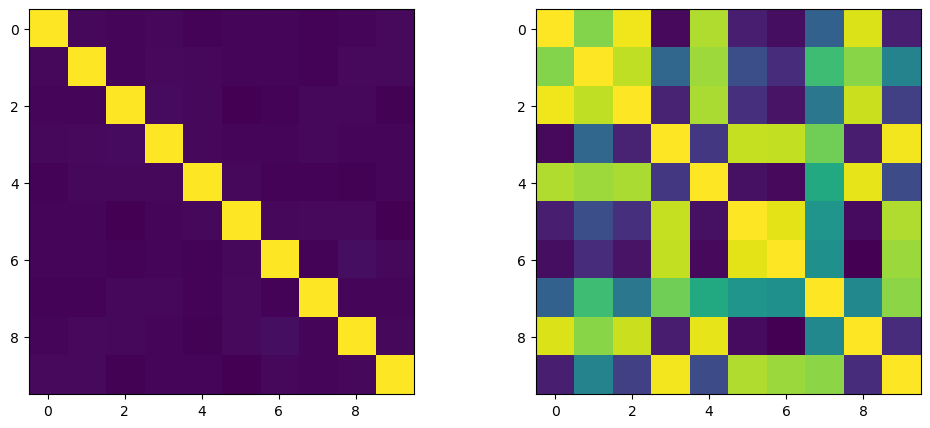

In [22]:
fig, axs = plt.subplots(1, 2, figsize = (12, 5))
axs[0].imshow(prior_samples6["corr_mat"].mean(axis=0))
axs[1].imshow(samples6["corr_mat"].mean(axis=0))

In [23]:
def model4(X, n_counties, Ys=None):
    year_effect = numpyro.sample("year_effect", dist.Normal(jnp.zeros(X.shape), 1.0))
    county_effect = numpyro.sample("county_effect", dist.Normal(jnp.zeros(n_counties), 1.0))
    county_variance = numpyro.sample("county_variance", dist.Exponential(2.0 * jnp.ones(n_counties)))

    numpyro.sample(
        "Ys",
        dist.Normal(county_effect[:, None] + year_effect[None, :], county_variance[:, None]),
        obs=Ys
    )

to_infer = (
    votes_over_time.loc[votes_over_time.reset_index()["county_fips"].unique()[:100], "p_DEMOCRAT"]
    .reset_index()
    .pivot_table(columns=["county_fips"], index="year")
)
to_infer = to_infer.fillna(to_infer.mean(axis=0))
X = to_infer.index.to_numpy()
Ys = jax.scipy.special.logit(to_infer.to_numpy().T)

args = {
    "init_strategy": "value",
    "num_warmup": 1_000,
    "num_samples": 10_000,
    "num_chains": 2,
}
samples4 = run_inference(model4, args, rngs[0], X, len(Ys), Ys)

/tmp/ipykernel_8063/2384314660.py:89: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|██████████| 11000/11000 [00:22<00:00, 493.68it/s, 63 steps of size 7.68e-02. acc. prob=0.87]



                         mean       std    median      5.0%     95.0%     n_eff     r_hat
   county_effect[0]     -0.56      0.11     -0.56     -0.72     -0.38    523.44      1.01
   county_effect[1]     -0.75      0.11     -0.74     -0.92     -0.56    594.00      1.01
   county_effect[2]      0.40      0.10      0.40      0.24      0.56    462.49      1.01
   county_effect[3]     -0.53      0.17     -0.53     -0.81     -0.26   1394.45      1.00
   county_effect[4]     -1.24      0.25     -1.25     -1.65     -0.83   3011.96      1.00
   county_effect[5]      1.48      0.13      1.48      1.25      1.69    849.45      1.00
   county_effect[6]      0.22      0.10      0.22      0.05      0.38    459.72      1.01
   county_effect[7]     -0.21      0.13     -0.21     -0.41     -0.00    732.77      1.00
   county_effect[8]      0.25      0.10      0.25      0.10      0.42    471.46      1.01
   county_effect[9]     -0.62      0.29     -0.63     -1.10     -0.16   3761.53      1.00
  county_

In [24]:
from numpyro.infer import Predictive
prior_predictive4 = Predictive(model4, num_samples=2_000)
prior_samples4 = prior_predictive4(rngs[5], X, len(Ys))
posterior_predictive4 = Predictive(model4, samples4)
posterior_samples4 = posterior_predictive4(rngs[4], X, len(Ys))

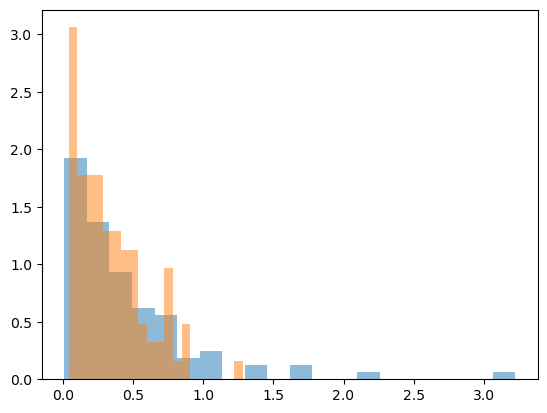

In [25]:
i = 2
plt.hist(prior_samples4["county_variance"][i], density=True, bins=20, alpha=0.5)
plt.hist(samples4["county_variance"][i], density=True, bins=20, alpha=0.5)
plt.show()

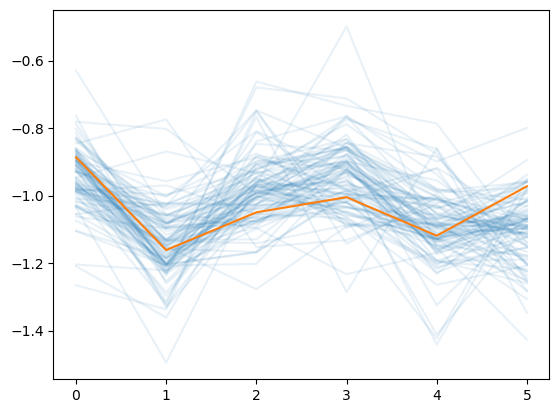

In [26]:
i = 0
for j in range(100):
  plt.plot(posterior_samples4["Ys"][j, i], alpha=0.1, color="C0")
plt.plot(Ys[i], color="C1")

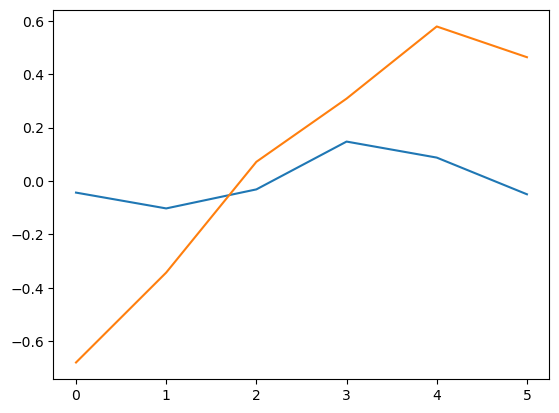

In [41]:
residuals = posterior_samples4["Ys"].mean(axis=0) - Ys[:, :]

fig, ax = plt.subplots()
i, j = 1, 4
ax.plot(residuals[i])
ax.plot(residuals[j])

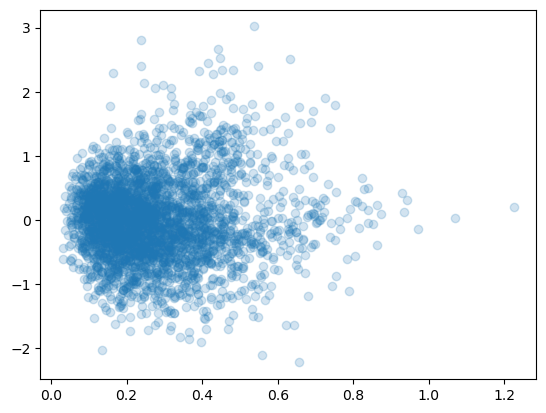

In [221]:
plt.scatter(samples4["county_variance"].mean(axis = 0), samples4["county_effect"].mean(axis=0), alpha = 0.2)

/home/packer.61/mambaforge/envs/pystats/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/packer.61/mambaforge/envs/pystats/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

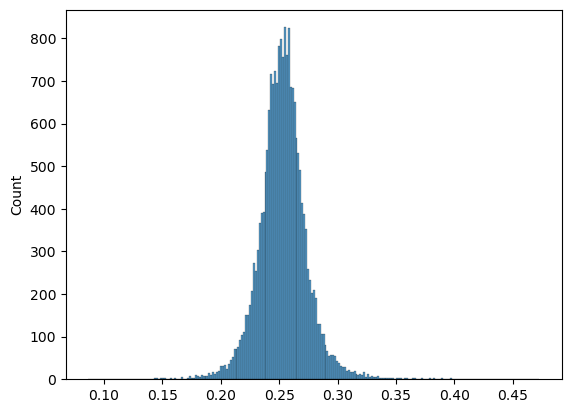

In [47]:
i = 0
posterior_probs = jax.scipy.special.expit(posterior_samples4["Ys"][:, i, -1])
sns.histplot(posterior_probs)

In [10]:
def model7(X, n_counties, Ys=None):
    year_effect = numpyro.sample("year_effect", dist.Normal(jnp.zeros(X.shape), 1.0))
    county_effect = numpyro.sample("county_effect", dist.Normal(jnp.zeros(n_counties), 1.0))
    county_variance = numpyro.sample("county_variance", dist.Exponential(2.0 * jnp.ones(n_counties)))

    numpyro.sample(
        "Ys",
        dist.StudentT(4, county_effect[:, None] + year_effect[None, :], county_variance[:, None]),
        obs=Ys
    )

to_infer = (
    votes_over_time.loc[votes_over_time.reset_index()["county_fips"].unique()[:], "p_DEMOCRAT"]
    .reset_index()
    .pivot_table(columns=["county_fips"], index="year")
)
to_infer = to_infer.fillna(to_infer.mean(axis=0))
X = to_infer.index.to_numpy()
Ys = jax.scipy.special.logit(to_infer.to_numpy().T)

args = {
    "init_strategy": "value",
    "num_warmup": 1_000,
    "num_samples": 2_000,
    "num_chains": 1,
}
samples7 = run_inference(model7, args, rngs[0], X, len(Ys), Ys)

prior_predictive7 = Predictive(model7, num_samples=2_000)
prior_samples7 = prior_predictive7(rngs[5], X, len(Ys))

sample: 100%|██████████| 3000/3000 [05:16<00:00,  9.47it/s, 63 steps of size 7.48e-02. acc. prob=0.88] 



                           mean       std    median      5.0%     95.0%     n_eff     r_hat
     county_effect[0]     -0.49      0.10     -0.49     -0.66     -0.34   1242.17      1.00
     county_effect[1]     -0.68      0.08     -0.69     -0.80     -0.57   1891.77      1.00
     county_effect[2]      0.46      0.08      0.46      0.33      0.60   1262.33      1.00
     county_effect[3]     -0.51      0.10     -0.52     -0.66     -0.35    872.03      1.00
     county_effect[4]     -1.27      0.21     -1.29     -1.57     -0.91   2170.06      1.00
     county_effect[5]      1.51      0.15      1.51      1.29      1.75   2312.48      1.00
     county_effect[6]      0.28      0.09      0.28      0.13      0.43   1496.82      1.00
     county_effect[7]     -0.16      0.08     -0.16     -0.26     -0.02    670.36      1.00
     county_effect[8]      0.32      0.08      0.32      0.19      0.44   1109.97      1.00
     county_effect[9]     -0.64      0.26     -0.66     -1.04     -0.21   2417.

NameError: name 'samples4' is not defined

In [11]:

posterior_predictive7 = Predictive(model7, samples7)
posterior_samples7 = posterior_predictive7(rngs[4], X, len(Ys))

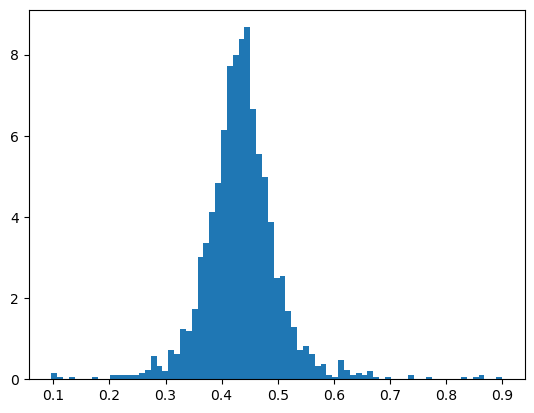

In [27]:
i = 2
posterior_probs = jax.scipy.special.expit(posterior_samples7["Ys"][:, i, -1])
plt.hist(posterior_probs, bins="auto", density=True)
plt.show()


In [32]:
Ys = posterior_samples7["Ys"]
probs = jax.vmap(lambda data : jax.scipy.stats.gaussian_kde(jax.scipy.special.expit(data))(0.5))(Ys[:, :, -1].swapaxes(0, 1)).flatten()
probs

Index(['01001', '01003', '01005', '01007', '01009', '01011', '01013', '01015',
       '01017', '01019',
       ...
       '56027', '56029', '56031', '56033', '56035', '56037', '56039', '56041',
       '56043', '56045'],
      dtype='object', name='county_fips', length=3156)

In [47]:
pivot_odds_df = pd.DataFrame(probs / votes_over_time.reset_index().groupby("county_fips").mean()["total_votes"]).rename({"total_votes" : "pivot_odds"}, axis=1)
pivot_odds_df["log_pivot_odds"] = np.log(pivot_odds_df["pivot_odds"] + 1e-16)
pivot_odds_df.to_csv(path_data / "partisan_county_pivot_odds.csv")

In [201]:
def model5(X, n_counties, Ys=None):
    year_second_effect = numpyro.sample("year_second_effect", dist.Normal(jnp.zeros(X.shape[0]), 1.0))
    county_second_effect = numpyro.sample("county_second_effect", dist.Exponential(jnp.ones(n_counties)))

    total_effect = county_second_effect[:, None] * year_second_effect[None, :]

    year_effect = numpyro.sample("year_effect", dist.Normal(jnp.zeros(X.shape), 1.0))
    county_effect = numpyro.sample("county_effect", dist.Normal(jnp.zeros(n_counties), 2.0))
    county_variance = numpyro.sample("county_variance", dist.Exponential(jnp.ones(n_counties)))

    numpyro.sample(
        "Ys",
        dist.Normal(county_effect[:, None] + year_effect[None, :] + total_effect, county_variance[:, None]),
        obs=Ys
    )

to_infer = (
    votes_over_time.loc[votes_over_time.reset_index()["county_fips"].unique()[:1000], "p_DEMOCRAT"]
    .reset_index()
    .pivot_table(columns=["county_fips"], index="year")
)
to_infer = to_infer.fillna(to_infer.mean(axis=0))
X = to_infer.index.to_numpy()
Ys = jax.scipy.special.logit(to_infer.to_numpy().T)

args = {
    "init_strategy": "value",
    "num_warmup": 500,
    "num_samples": 2_000,
    "num_chains": 1,
}
mcmc = run_inference(model5, args, rngs[0], X, len(Ys), Ys, fullmcmc=True)
samples = mcmc.get_samples()
# Ys[0]

sample: 100%|██████████| 2500/2500 [01:26<00:00, 28.78it/s, 127 steps of size 3.60e-02. acc. prob=0.84]



                               mean       std    median      5.0%     95.0%     n_eff     r_hat
         county_effect[0]     -0.70      0.15     -0.70     -0.94     -0.47     22.86      1.04
         county_effect[1]     -0.80      0.13     -0.80     -1.00     -0.60     21.73      1.03
         county_effect[2]      0.28      0.12      0.28      0.08      0.48     17.65      1.05
         county_effect[3]     -0.35      0.21     -0.34     -0.69     -0.02     85.69      1.00
         county_effect[4]     -0.83      0.27     -0.82     -1.23     -0.38    163.99      1.00
         county_effect[5]      1.18      0.12      1.18      0.98      1.36     12.60      1.09
         county_effect[6]      0.09      0.13      0.10     -0.14      0.30     23.02      1.08
         county_effect[7]     -0.16      0.16     -0.15     -0.41      0.09     39.93      1.01
         county_effect[8]      0.17      0.13      0.17     -0.03      0.38     18.91      1.05
         county_effect[9]      0.00    

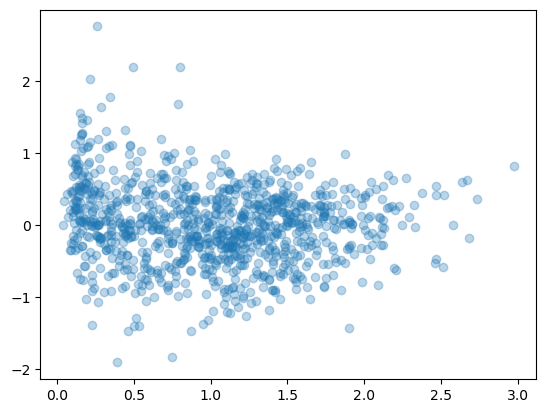

In [203]:
secondary_effects_sensitivity = samples["county_second_effect"].T
county_effect = samples["county_effect"].T
fig, ax = plt.subplots()

ax.scatter(secondary_effects_sensitivity.mean(axis=-1), county_effect.mean(axis=-1), alpha = 0.3)

In [204]:
prior_predictive = Predictive(model5, num_samples=2_000)
prior_samples = prior_predictive(rngs[5], X, len(Ys))
posterior_predictive = Predictive(model5, samples)
posterior_samples = posterior_predictive(rngs[4], X, len(Ys))

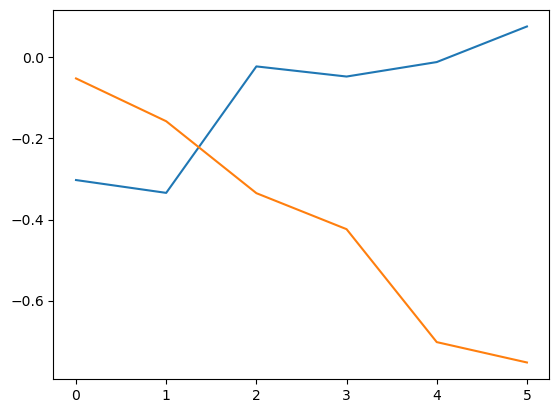

In [205]:
plt.plot(samples["year_effect"].mean(axis=0))
plt.plot(samples["year_second_effect"].mean(axis=0))

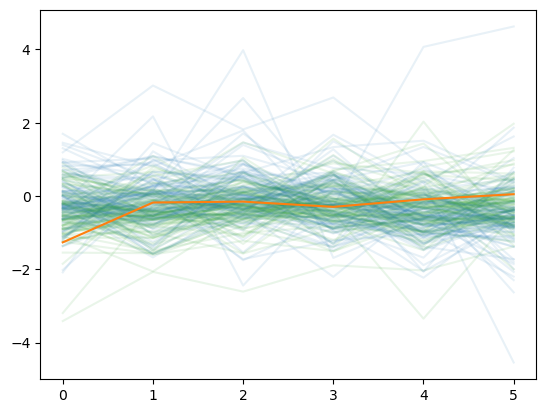

In [208]:
i = 101
for j in range(100):
  plt.plot(predictions[j, i], alpha=0.1, color="C0")
  plt.plot(posterior_samples["Ys"][j, i], alpha =0.1, color="C2")
plt.plot(Ys[i], color="C1")

In [212]:
samples["county_variance"].mean(axis = 0)

Array([0.15632327, 0.12352171, 0.12133458, 0.23055753, 0.29712307,
       0.10366409, 0.14436756, 0.16791783, 0.12876388, 0.2732283 ,
       0.23815285, 0.11935538, 0.09767937, 0.14612578, 0.22802986,
       0.21650745, 0.14801797, 0.10942258, 0.11432631, 0.23813115,
       0.20895338, 0.32615504, 0.16045813, 0.12264605, 0.14897104,
       0.16544257, 0.17054188, 0.23837155, 0.20299895, 0.15467802,
       0.22671315, 0.1324642 , 0.10171671, 0.12833269, 0.09351858,
       0.22094598, 0.06257732, 0.2048755 , 0.1283603 , 0.21962868,
       0.07158457, 0.24192765, 0.10798244, 0.17459004, 0.15674946,
       0.10026285, 0.23330757, 0.289431  , 0.03686685, 0.09598625,
       0.19805555, 0.22780007, 0.09177776, 0.10634895, 0.09203064,
       0.16195698, 0.1511572 , 0.29544845, 0.17608593, 0.10670912,
       0.12353109, 0.18495253, 0.09020058, 0.2698042 , 0.15891972,
       0.16127457, 0.18104881, 0.6918145 , 0.33490157, 0.6571486 ,
       0.19343108, 0.24441248, 0.28734156, 0.42543477, 0.73079

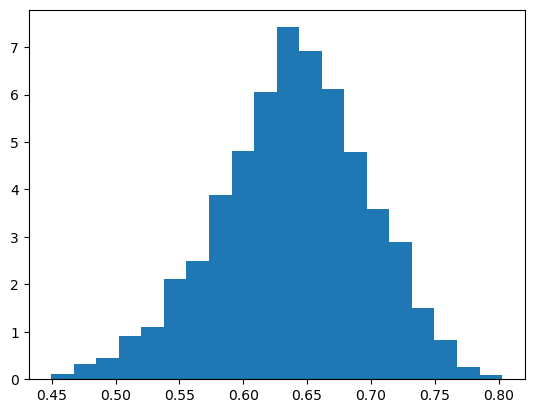

In [196]:
firstpredicted_margin = jax.scipy.special.expit(prediction[1][:, -1])
lower_q, upper_q = 0.05, 0.95
plt.hist(predicted_margin, bins=20, density=True)

plt.show()

In [95]:
to_save = partisan_votes_by_jurisdiction[["pivot_odds", "log_pivot_odds"]]
to_save.index = to_save.index.astype(int).to_series().apply(lambda i: str(i).zfill(5))
to_save.to_csv(path_data / "partisan_county_pivot_odds.csv")

NameError: name 'partisan_votes_by_jurisdiction' is not defined